In [481]:
import torch

gnDataset = 3
gBase_path = 'CAS771/Task2_data'
gnClasses = 5
gSaveModelAll = True

gDropout_rate = [0.9, 0.9, 0.9]
gBatch_momentum = [0.1, 0.1, 0.1]
gLearning_rate = [0.0001, 0.0001, 0.0001]
gWeight_decay = [1e-4, 1e-4, 1e-3]
gOpt_Momentum = [0.9, 0.9, 0.9]

gData_batch_size = 32
gEarly_stop_patience = 60
gnEpochs = 500
gbData_augmentation = True

gModel_names = ["cnn2", "cnn2", "cnn2"] # "resnet", "cnn"
gOptimizer_names = ["Adam", "Adam", "Adam"] # "Adam", "SGD"
gCriterion_names = ["CrossEntropyLoss", "CrossEntropyLoss", "CrossEntropyLoss"]


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/kimw30
Displaying images for all classes:


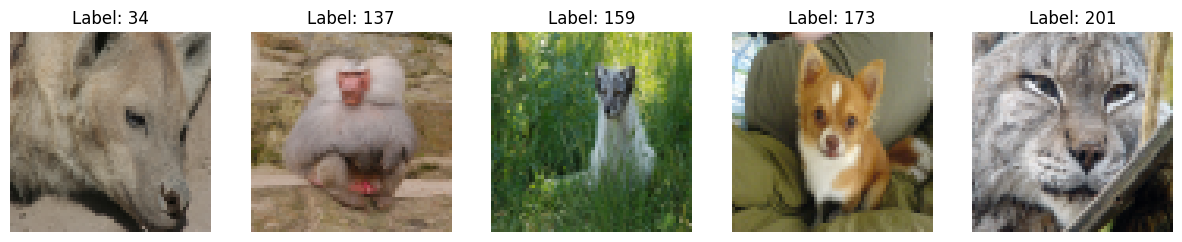

In [482]:
import os
import torch
import imageio
import numpy as np
import matplotlib.pyplot as plt

def display_images(data, labels):
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
    for i, label in enumerate(unique_labels):
        idx = np.where(labels == label)[0][0]
        image = data[idx]
        axes[i].imshow(image.astype(np.uint8))
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

def load_pth(file_path):
    raw_data = torch.load(file_path)
    return raw_data['data'].numpy(), raw_data['labels'].numpy()

if __name__ == '__main__':
    print(os.getcwd())  # 현재 작업 디렉토리 출력
    # Load and display images for each class in the dataset
    train_data, train_labels = load_pth('CAS771/Task2_data/train_dataB_model_1.pth')
    print('Displaying images for all classes:')
    display_images(train_data, train_labels)

/home/kimw30
Displaying images for all classes:


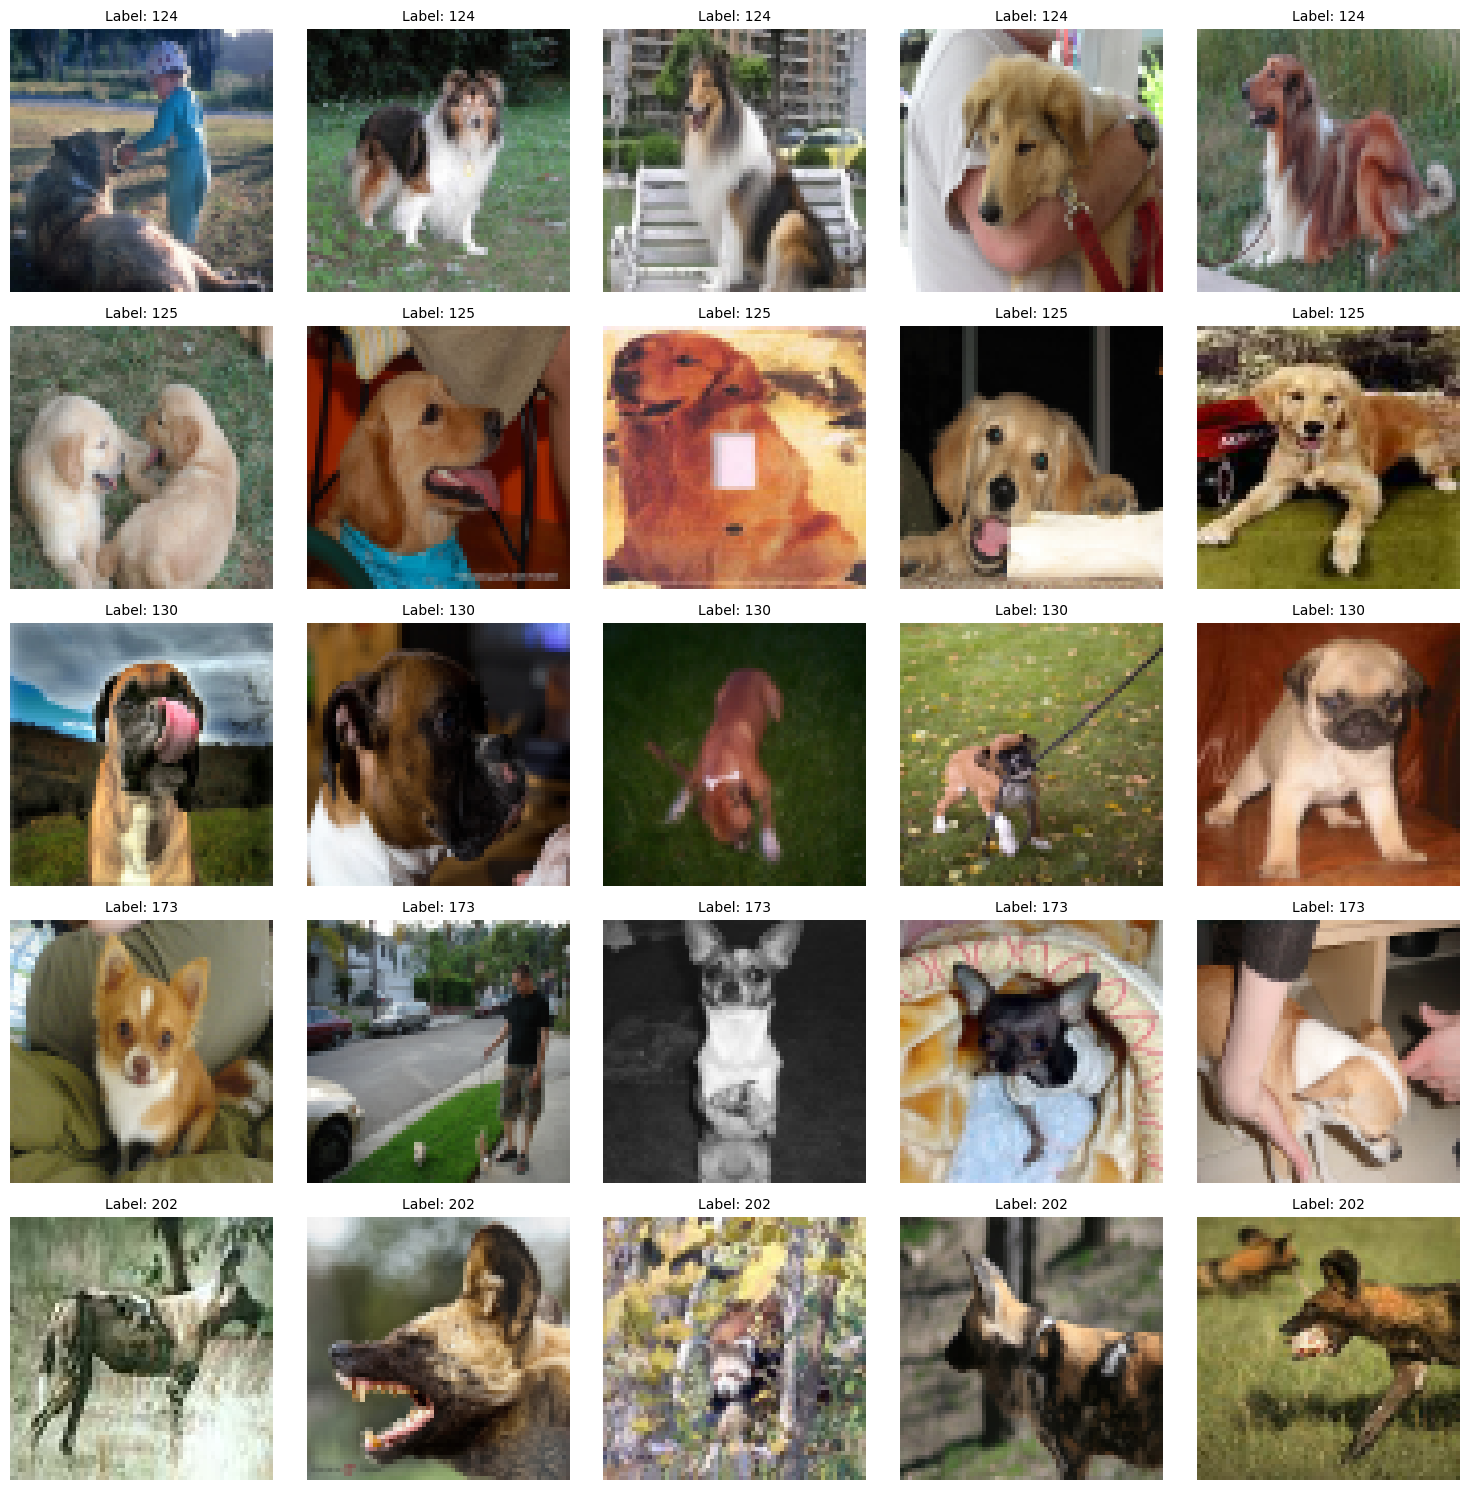

In [483]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def display_images(data, labels):
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    samples_per_class = 5  # 각 클래스당 출력할 이미지 개수
    
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    
    for i, label in enumerate(unique_labels):
        idxs = np.where(labels == label)[0][:samples_per_class]  # 해당 클래스에서 최대 5개 선택
        for j, idx in enumerate(idxs):
            image = data[idx]
            axes[i, j].imshow(image.astype(np.uint8))
            axes[i, j].set_title(f'Label: {label}', fontsize=10)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

def load_pth(file_path):
    raw_data = torch.load(file_path)
    return raw_data['data'].numpy(), raw_data['labels'].numpy()

if __name__ == '__main__':
    print(os.getcwd())  # 현재 작업 디렉토리 출력
    # Load and display images for each class in the dataset
    train_data, train_labels = load_pth('CAS771/Task2_data/train_dataB_model_3.pth')
    print('Displaying images for all classes:')
    display_images(train_data, train_labels)


In [484]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

class CAS771Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform and not isinstance(img, torch.Tensor):
            img = self.transform(img)
        return img, label

def _load_data(train_data_path):
    raw_data = torch.load(train_data_path)
    data = raw_data['data']
    data = data.permute(0, 3, 1, 2)
    labels = raw_data['labels']
    labels = labels.tolist()
    return data, labels

def remap_labels(labels, class_mapping):
    return [class_mapping[label] for label in labels]

def load_class_names(filepath):
    with open(filepath, 'r') as file:
        classes = [line.strip() for line in file]
    return classes

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_layers(model):
    layer_count = 0
    for module in model.children():
        if not isinstance(module, nn.Dropout):  # deduct Dropout
            layer_count += 1
    return layer_count


class CAS771Plot():
    def __init__(self, model, criterion, device, train_dataloader, test_dataloader, model_num):
        self.model = model
        self.criterion = criterion 
        self.device = device
        self.train_losses = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.running_loss = 0.0
        self.model_num = model_num + 1
    
    def init_running_loss(self):
        self.running_loss = 0.0

    def add_loss(self, loss):
        self.running_loss += loss

    def append(self, epoch):
        train_loss = self.running_loss / len(self.train_dataloader)
        validation_loss, validation_accuracy = self._validate()
        self.train_losses.append(train_loss)
        self.validation_losses.append(validation_loss)
        self.validation_accuracies.append(validation_accuracy)
        self._print(epoch, train_loss, validation_loss, validation_accuracy)
        return validation_loss, validation_accuracy

    def plot(self):
        self._plot_metrics(self.train_losses, self.validation_losses, self.validation_accuracies, self.model_num)
    
    def _print(self, epoch, train_loss, validation_loss, validation_accuracy):
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    def _validate(self):
        self.model.eval()  # evaluation mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        with torch.no_grad():  # disable gradient calculations
            for inputs, labels in self.test_dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
        
        validation_loss = running_loss / len(self.test_dataloader)
        validation_accuracy = correct_predictions / total_samples
        return validation_loss, validation_accuracy

    def _plot_metrics(self, train_losses, validation_losses, validation_accuracies, model_num):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
        plt.title(f'Model {model_num} Learning per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o', color='green')
        plt.title(f'Model {model_num} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()    


class CAS771EarlyStopping():
    def __init__(self):
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def isStop(self, validation_loss, validation_accuray, m=-1):
        if validation_loss < self.best_val_loss: # 검증 손실이 감소하면 best_val_loss 업데이트
            self.best_val_loss = validation_loss
            self.patience_counter = 0
        else:
            self.patience_counter += 1

        if m == 0 and gModel_names[m] == "cnn2":
            if validation_accuray > 0.7:
                return True
        elif m == 1 and gModel_names[m] == "cnn2":
            if validation_accuray > 0.8:
                return True
        elif m == 2 and gModel_names[m] == "cnn2":
            if validation_accuray > 0.64:
                return True
        
        if self.patience_counter >= gEarly_stop_patience: # 검증 손실이 감소하지 않으면 학습 종료
            print("Early stopping")
            return True
        else:
            return False

def get_data_augmentation(mode):
    if gbData_augmentation == False:
        return None
    
    if mode == "train":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(), # inverse left-right
            transforms.RandomRotation(degrees=15), # random rotate
            transforms.RandomResizedCrop(32, scale=(0.8, 1.0)), # random crop
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalization
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

def load_data(train_data_path, test_data_path, m=0, save_class_mapping=True):
    train_data, train_labels = _load_data(train_data_path)
    unique_labels = sorted(set(train_labels))
    class_mapping = {label: i for i, label in enumerate(unique_labels)}
    print(f"Class mapping: {class_mapping}")
    
    if train_data_path == None:
        train_dataloader = None
    else:
        train_remapped_labels = remap_labels(train_labels, class_mapping)
        transform = get_data_augmentation("train")
        train_dataset = CAS771Dataset(train_data, train_remapped_labels, transform=transform)
        train_dataloader = DataLoader(train_dataset, batch_size=gData_batch_size, shuffle=True, drop_last=False)

        if save_class_mapping:
            # Save the mapping to a file
            class_mapping_path = f'{gBase_path}/class_mapping_model_{m+1}.pkl'
            with open(class_mapping_path, "wb") as f:
                pickle.dump(class_mapping, f)

    if test_data_path == None:
        test_dataloader = None
    else:
        test_data, test_labels = _load_data(test_data_path)
        remapped_test_labels = remap_labels(test_labels, class_mapping)
        transform = get_data_augmentation("test")
        test_dataset = CAS771Dataset(test_data, remapped_test_labels, transform=transform)
        test_dataloader = DataLoader(test_dataset, batch_size=gData_batch_size, shuffle=False, drop_last=False)

    return train_dataloader, test_dataloader

In [485]:
train_data_paths = [f'{gBase_path}/train_dataB_model_{i}.pth' for i in range(1, gnDataset+1)]
test_data_paths = [f'{gBase_path}/val_dataB_model_{i}.pth' for i in range(1, gnDataset+1)]
print(train_data_paths)
print(test_data_paths)

classes_path = gBase_path + '/cifar100_classes.txt'
classes = load_class_names(classes_path)
print(classes)

['CAS771/Task2_data/train_dataB_model_1.pth', 'CAS771/Task2_data/train_dataB_model_2.pth', 'CAS771/Task2_data/train_dataB_model_3.pth']
['CAS771/Task2_data/val_dataB_model_1.pth', 'CAS771/Task2_data/val_dataB_model_2.pth', 'CAS771/Task2_data/val_dataB_model_3.pth']
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', '

In [486]:
# CBAM Block 정의 (가벼운 Attention Mechanism)
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
        # Spatial Attention
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

    def forward(self, x):
        b, c, _, _ = x.size()
        
        # Channel Attention
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        scale = (avg_out + max_out).view(b, c, 1, 1)
        x = x * scale

        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        scale = torch.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))
        x = x * scale
        return x

In [487]:
# Define Basic Block (Residual Block)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.0, batch_momentum=0.1):
        super(BasicBlock, self).__init__()
        # 1st Convolution Layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=batch_momentum)
        
        # 2nd Convolution Layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=batch_momentum)
        
        # Skip connection (identity)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels, momentum=batch_momentum)
            )

        # Dropout Layer (After Batch Normalization)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Residual connection + ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # skip connection
        out = F.relu(out)
        return out
    
# Define Modified ResNet-18
class ResNet18(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5, batch_momentum=0.1):
        super(ResNet18, self).__init__()
        self.in_channels = 32  
        # 1st Layer (Conv + Maxpool)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(32, momentum=batch_momentum)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Residual Blocks (each block is BasicBlock)
        #self.layer0 = self._make_layer(64, 2, stride=1, dropout_rate=dropout_rate/2)   
        self.layer1 = self._make_layer(64, 2, 
                                       stride=1, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum)   
        self.layer2 = self._make_layer(128, 2, stride=2, 
                                       dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum) 
        self.layer3 = self._make_layer(256, 2, stride=2, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum) 
        self.layer4 = self._make_layer(256, 2, stride=2, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum) 
        # Fully Connected Layer
        self.fc = nn.Linear(256, num_classes) 
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def _make_layer(self, out_channels, num_blocks, stride, dropout_rate, batch_momentum):
        layers = []
        layers.append(BasicBlock(self.in_channels, 
                                 out_channels, 
                                 stride, 
                                 dropout_rate=dropout_rate,
                                 batch_momentum=batch_momentum))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels, dropout_rate=dropout_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 1st Convolution + Maxpool
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        # Residual Blocks
        #x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Fully Connected
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.dropout(x)      # Apply Dropout
        x = self.fc(x)
        
        return x

In [488]:
import torchvision.models as models

class ResNet50(nn.Module):
    def __init__(self, num_classes, pretrained=False, use_small_input=False, dropout_rate=False):        
        super(ResNet50, self).__init__()
        self.dropout_rate = dropout_rate        
        if pretrained:
            self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)        
        else:
            self.model = models.resnet50(weights=None)  
    
        if use_small_input:        
            # Example: kernel_size=3, stride=1 for 64x64
            self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            self.model.bn1 = nn.BatchNorm2d(64)
            self.model.layer2[0].conv2.stride = (1,1)           
        if self.model.layer2[0].downsample is not None:
            self.model.layer2[0].downsample[0].stride = (1,1)        

        #for param in self.model.parameters():
        #    param.requires_grad = False

        #if use_small_input:
        #    self.model.conv1.requires_grad_(True)
        #    self.model.bn1.requires_grad_(True)
       
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
        #self.model.fc.requires_grad_(True)
    
    def forward(self, x):        
        return self.model(x)

In [489]:
'''
gnGPU = "0"
gnDataset = 3
gBase_path = 'CAS771/Task1_data'
gnClasses = 5
gDropout_rate = 0.9
gBatch_momentum = 0.1
gLearning_rate = 0.00001
gWeight_decay = 1e-3
gOpt_Momentum = 0.9
gData_batch_size = 32
gEarly_stop_patience = 15
gnEpochs = 200
gbData_augmentation = False

'''
class CNN_2(nn.Module):
    def __init__(self, num_classes, dropout_rate=gDropout_rate):
        super(CNN_2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=7, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 64, 64)
        dummy_output = self.pool2(F.relu(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 32)
        self.fc2 = nn.Linear(32, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x, return_embedding=False):
        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        #x = self.cbam(x)  # CBAM 적용
        x = self.pool2(x) # second pooling

        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        embedding = self.dropout(F.relu(self.fc1(x)))

        if return_embedding:
            return embedding  # Feature vector 반환
        
        x = self.fc2(embedding)
        return x

In [490]:
'''
gnGPU = "0"
gnDataset = 3
gBase_path = 'CAS771/Task1_data'
gnClasses = 5
gDropout_rate = 0.9
gBatch_momentum = 0.1
gLearning_rate = 0.00001
gWeight_decay = 1e-3
gOpt_Momentum = 0.9
gData_batch_size = 32
gEarly_stop_patience = 15
gnEpochs = 200
gbData_augmentation = False

'''
class CNN_3(nn.Module):
    def __init__(self, num_classes, dropout_rate=gDropout_rate):
        super(CNN_3, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=7, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=9, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 64, 64)
        dummy_output = self.pool2(F.relu(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 32)
        self.fc2 = nn.Linear(32, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x, return_embedding=False):
        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        #x = self.cbam(x)  # CBAM 적용
        x = self.pool2(x) # second pooling

        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        embedding = self.dropout(F.relu(self.fc1(x)))

        if return_embedding:
            return embedding  # Feature vector 반환
        
        x = self.fc2(embedding)
        return x

In [491]:
class CNN_1(nn.Module):
    def __init__(self, num_classes, dropout_rate=gDropout_rate):
        super(CNN_1, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=4, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 64, 64)
        dummy_output = self.pool2(F.relu(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 32)
        self.fc2 = nn.Linear(32, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x, return_embedding=False):
        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        #x = self.cbam(x)  # CBAM 적용
        x = self.pool2(x) # second pooling

        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        embedding = self.dropout(F.relu(self.fc1(x)))

        if return_embedding:
            return embedding  # Feature vector 반환
        
        x = self.fc2(embedding)
        return x

In [492]:
'''
gnGPU = "0"
gnDataset = 3
gBase_path = 'CAS771/Task1_data'
gnClasses = 5
gDropout_rate = 0.9
gBatch_momentum = 0.1
gLearning_rate = 0.00001
gWeight_decay = 1e-3
gOpt_Momentum = 0.9
gData_batch_size = 32
gEarly_stop_patience = 15
gnEpochs = 200
gbData_augmentation = False

'''
class CNN2(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CNN2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 64, kernel_size=5, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=7, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 64, 64)
        dummy_output = self.pool2(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 1280)
        self.fc2 = nn.Linear(1280, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x, return_embedding=False):
        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x) # second pooling
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        x = self.dropout(F.relu(self.fc1(x)))

        if return_embedding:
            return x  # Feature vector 반환

        x = self.fc2(x)
        return x

In [493]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ImprovedCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Extra Conv Layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Extra Conv Layer
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Extra Conv Layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # **Global Average Pooling**
        self.gap = nn.AdaptiveAvgPool2d(1)  # Output: (batch_size, 256, 1, 1)

        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256, 128),  # Reduced size
            nn.ReLU(),
            nn.Dropout(0.3),  # Reduced dropout
            nn.Linear(128, num_classes)  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.gap(x)  # Apply Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten before FC layers
        return self.fc_layers(x)


In [494]:
def _get_model(model_name, dropout_rate, batch_momentum, m = 0):
    if model_name == "resnet":
        model = ResNet18(num_classes=gnClasses, 
                        dropout_rate=dropout_rate, 
                        batch_momentum=batch_momentum).to(device)
    elif model_name == "cnn_1":
        model = CNN_1(num_classes=gnClasses,
                     dropout_rate=dropout_rate).to(device)
    elif model_name == "cnn_2":
        model = CNN_2(num_classes=gnClasses,
                     dropout_rate=dropout_rate).to(device)
    elif model_name == "cnn_3":
        model = CNN_3(num_classes=gnClasses,
                     dropout_rate=dropout_rate).to(device)
    elif model_name == "cnn2":
        model = CNN2(num_classes=gnClasses,
                     dropout_rate=dropout_rate).to(device)
    elif model_name == "imprv_cnn":
        model = ImprovedCNN(num_classes=gnClasses).to(device)
    elif model_name == "pretrained":
        model = ResNet50(num_classes=gnClasses, pretrained=True, use_small_input=True, dropout_rate=dropout_rate).to(device)

    print(f"Model{m+1} parameters: {count_parameters(model)}")
    print(f"Model{m+1} Total layers: {count_layers(model)}")
    return model

def _get_optimizer(opname, model, learning_rate, weight_decay, opt_momentum, model_name="cnn"):
    if opname == "Adam":
        '''
        if model_name == "pretrained":
            params_to_update = []
            for name,param in model.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    print("\t",name)
            return optim.Adam(params_to_update, lr=learning_rate)
        '''
        return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif opname == "SGD":
        return optim.SGD(model.parameters(), lr=learning_rate, momentum = opt_momentum, weight_decay=weight_decay)

def _get_criterion(criterion_name):
    if criterion_name == "CrossEntropyLoss":
        return nn.CrossEntropyLoss()
    return nn.CrossEntropyLoss()

def get_models(model_names, optimizer_names, criterion_names):
    models = []
    optimizers = []
    criterions = []
    for m in range(gnDataset):
        models.append(_get_model(model_names[m], gDropout_rate[m], gBatch_momentum[m], m))
        if model_names[m] == "pretrained":
            optimizers.append(_get_optimizer(optimizer_names[m], models[m], gLearning_rate[m], gWeight_decay[m], gOpt_Momentum[m], model_names[m]))
        else:
            optimizers.append(_get_optimizer(optimizer_names[m], models[m], gLearning_rate[m], gWeight_decay[m], gOpt_Momentum[m]))
        criterions.append(_get_criterion(criterion_names[m]))
    
    return models, optimizers, criterions

    
def save_model(model, m=0, all=False):
    if all == True:
        model_saved_path = f"{gBase_path}/model{m+1}_all.pth"
        torch.save(model, model_saved_path)
    else:
        model_saved_path = f"{gBase_path}/model{m+1}_weights.pth"
        torch.save(model.state_dict(), model_saved_path)

    print(f"Model{m+1} is saved to: {model_saved_path}")

def load_model(model, m=0, all=False):
    if all == True:
        model_saved_path = f"{gBase_path}/model{m+1}_all.pth"
        model.load(model_saved_path)
    else:
        model_saved_path = f"{gBase_path}/model{m+1}_weights.pth"
        model.load_state_dict(torch.load(model_saved_path))

    print(f"Model{m+1} is loaded from: {model_saved_path}")


import matplotlib.pyplot as plt
import numpy as np

# 샘플 이미지 출력 함수 추가
def show_sample_images(dataloader, model_name, num_images=5):
    """ 학습 데이터에서 5개 샘플을 시각화하는 함수 """
    images, labels = next(iter(dataloader))  # 첫 번째 배치에서 이미지 가져오기
    images, labels = images[:num_images], labels[:num_images]  # 5개 이미지만 선택
    
    # 텐서를 NumPy 배열로 변환 (CPU로 이동 후)
    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # (B, C, H, W) → (B, H, W, C)

    # 이미지 출력
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(f"Sample Images from {model_name}", fontsize=14)
    for i in range(num_images):
        #class_name = classes[labels[i].item()]  # 클래스명 가져오기
        axes[i].imshow(images[i].astype(np.uint8))
        #axes[i].set_title(f"{class_name} ({labels[i].item()})", fontsize=10)  # 클래스명 + 레이블 추가
        axes[i].set_title(f"{labels[i].item()}", fontsize=10)
        axes[i].axis("off")
    plt.show()

def display_images(data, labels):
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
    for i, label in enumerate(unique_labels):
        class_name = classes[labels[i].item()]  # 클래스명 가져오기
        idx = np.where(labels == label)[0][0]
        image = data[idx]
        axes[i].imshow(image.astype(np.uint8))
        axes[i].set_title(f"{class_name} ({labels[i].item()})", fontsize=10)  # 클래스명 + 레이블 추가
        axes[i].axis('off')
    plt.show()

# 각 클래스에서 3개씩 샘플링하여 이미지 출력
def display_images_per_class(data, labels, samples_per_class=3):
    unique_labels = np.unique(np.array(labels))  # 고유한 클래스 라벨 추출
    num_classes = len(unique_labels)
    
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 2, num_classes * 2))
    fig.suptitle("Sample Images Per Class", fontsize=14)

    for i, label in enumerate(unique_labels):
        class_name = classes[label]  # 클래스명 가져오기
        indices = np.where(np.array(labels) == label)[0][:samples_per_class]  # 해당 클래스에서 3개 샘플링
        
        for j, idx in enumerate(indices):
            image = np.array(data[idx]).transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
            axes[i, j].imshow(image)
            axes[i, j].set_title(f"{class_name} ({label})", fontsize=8)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
'''
if __name__ == '__main__':
    for i in range(gnDataset):
        train_data, train_labels = _load_data(train_data_paths[i])
        display_images_per_class(train_data, train_labels, samples_per_class=3)
'''

"\nif __name__ == '__main__':\n    for i in range(gnDataset):\n        train_data, train_labels = _load_data(train_data_paths[i])\n        display_images_per_class(train_data, train_labels, samples_per_class=3)\n"

Model1 parameters: 7447845
Model1 Total layers: 10
Model2 parameters: 7447845
Model2 Total layers: 10
Model3 parameters: 7447845
Model3 Total layers: 10
Class mapping: {34: 0, 137: 1, 159: 2, 173: 3, 201: 4}


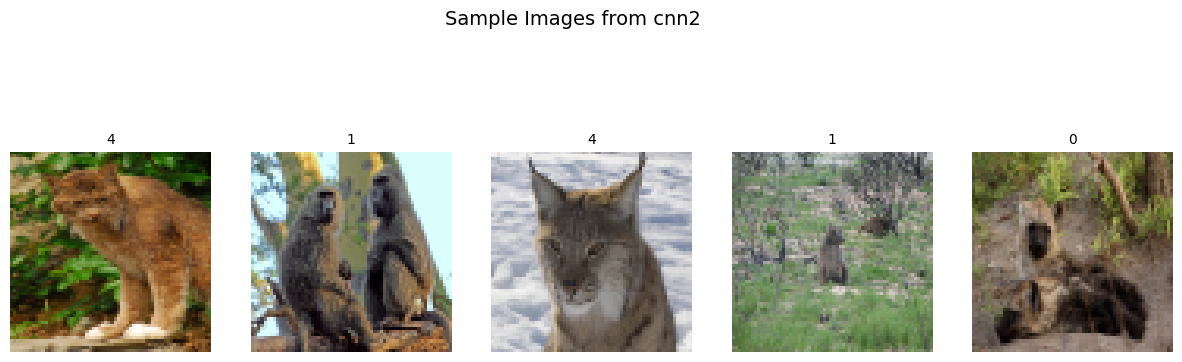

Epoch 1, Train Loss: 1.5826, Validation Loss: 1.2060, Validation Accuracy: 0.5240
Epoch 2, Train Loss: 1.3572, Validation Loss: 1.1505, Validation Accuracy: 0.5640
Epoch 3, Train Loss: 1.3197, Validation Loss: 1.1604, Validation Accuracy: 0.5760
Epoch 4, Train Loss: 1.2897, Validation Loss: 1.0788, Validation Accuracy: 0.5960
Epoch 5, Train Loss: 1.2403, Validation Loss: 1.0652, Validation Accuracy: 0.5840
Epoch 6, Train Loss: 1.2169, Validation Loss: 1.0283, Validation Accuracy: 0.6120
Epoch 7, Train Loss: 1.1831, Validation Loss: 1.0069, Validation Accuracy: 0.6280
Epoch 8, Train Loss: 1.1529, Validation Loss: 0.9908, Validation Accuracy: 0.5760
Epoch 9, Train Loss: 1.1152, Validation Loss: 0.9830, Validation Accuracy: 0.6320
Epoch 10, Train Loss: 1.0988, Validation Loss: 0.9988, Validation Accuracy: 0.5760
Epoch 11, Train Loss: 1.0729, Validation Loss: 0.9428, Validation Accuracy: 0.6280
Epoch 12, Train Loss: 1.0514, Validation Loss: 0.9382, Validation Accuracy: 0.6160
Epoch 13, Tra

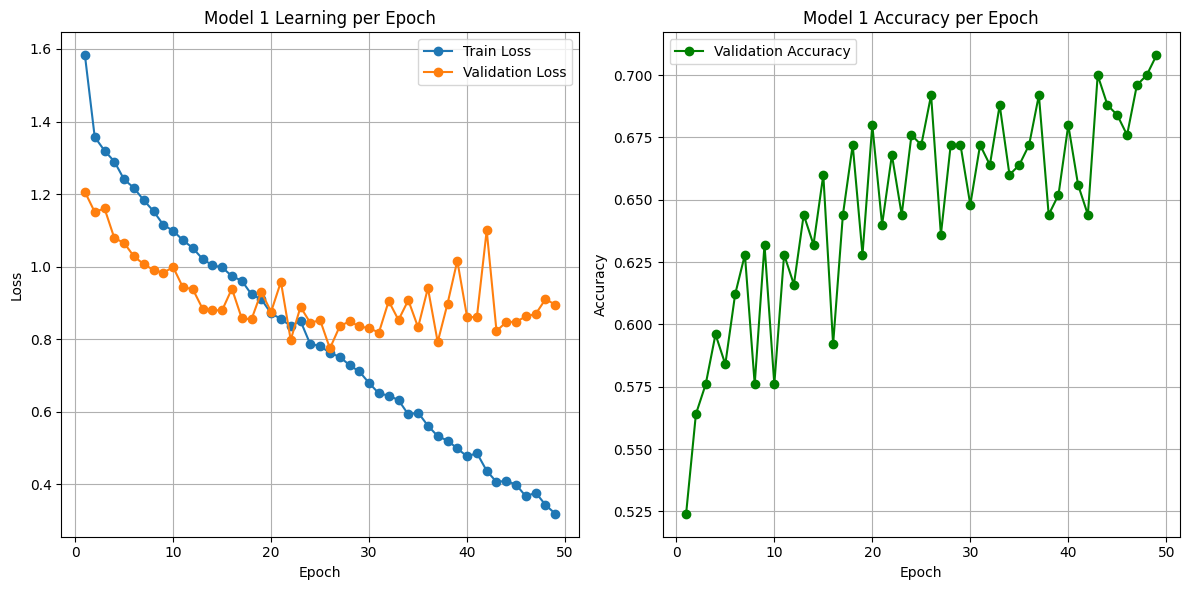

Model1 is saved to: CAS771/Task2_data/model1_all.pth
Class mapping: {24: 0, 34: 1, 80: 2, 135: 3, 202: 4}


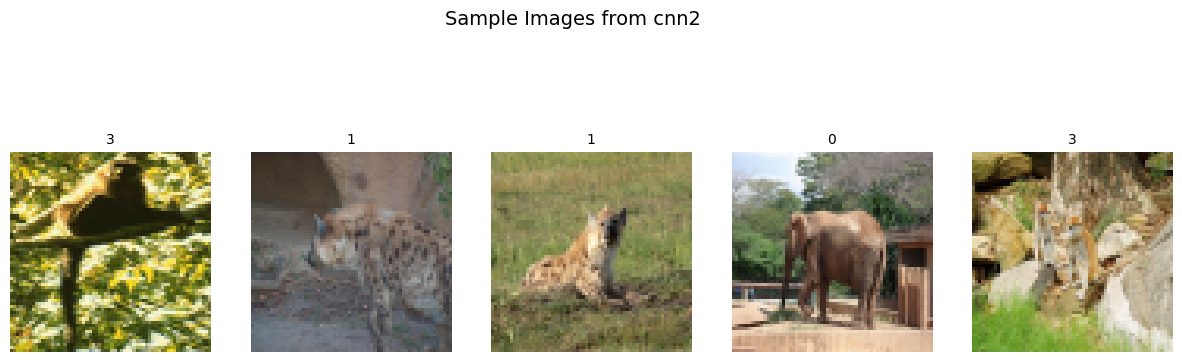

Epoch 1, Train Loss: 1.6227, Validation Loss: 1.2252, Validation Accuracy: 0.5600
Epoch 2, Train Loss: 1.3460, Validation Loss: 1.1441, Validation Accuracy: 0.5800
Epoch 3, Train Loss: 1.2594, Validation Loss: 1.0156, Validation Accuracy: 0.6560
Epoch 4, Train Loss: 1.2017, Validation Loss: 0.9621, Validation Accuracy: 0.6640
Epoch 5, Train Loss: 1.1460, Validation Loss: 0.8792, Validation Accuracy: 0.7000
Epoch 6, Train Loss: 1.0671, Validation Loss: 0.9700, Validation Accuracy: 0.6400
Epoch 7, Train Loss: 1.0313, Validation Loss: 0.7929, Validation Accuracy: 0.7160
Epoch 8, Train Loss: 0.9981, Validation Loss: 0.7751, Validation Accuracy: 0.7120
Epoch 9, Train Loss: 0.9639, Validation Loss: 0.7996, Validation Accuracy: 0.6920
Epoch 10, Train Loss: 0.8952, Validation Loss: 0.7510, Validation Accuracy: 0.7080
Epoch 11, Train Loss: 0.8619, Validation Loss: 0.7479, Validation Accuracy: 0.7320
Epoch 12, Train Loss: 0.8266, Validation Loss: 0.7288, Validation Accuracy: 0.7280
Epoch 13, Tra

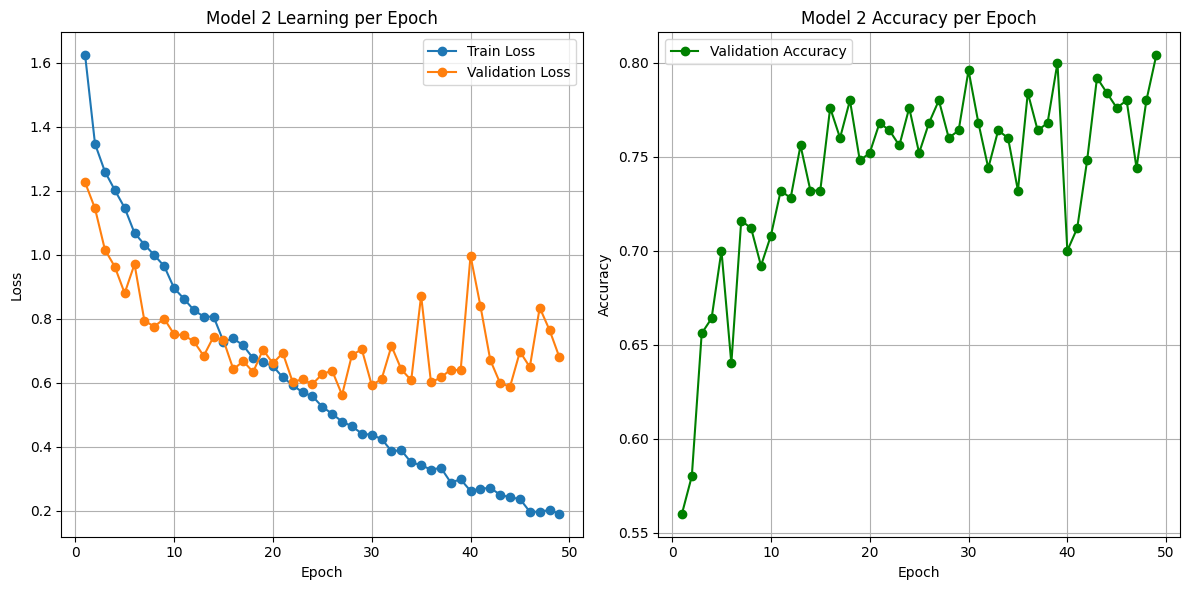

Model2 is saved to: CAS771/Task2_data/model2_all.pth
Class mapping: {124: 0, 125: 1, 130: 2, 173: 3, 202: 4}


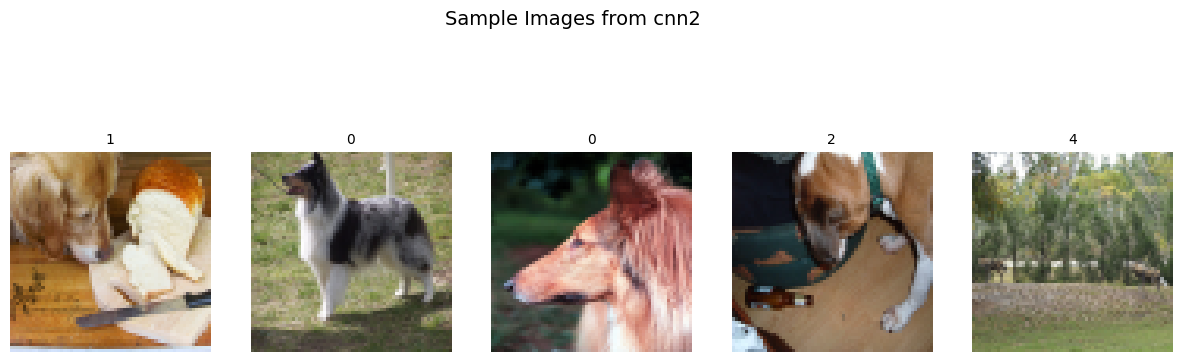

Epoch 1, Train Loss: 1.6874, Validation Loss: 1.4126, Validation Accuracy: 0.4120
Epoch 2, Train Loss: 1.4826, Validation Loss: 1.3327, Validation Accuracy: 0.4560
Epoch 3, Train Loss: 1.4035, Validation Loss: 1.2938, Validation Accuracy: 0.4680
Epoch 4, Train Loss: 1.3725, Validation Loss: 1.2229, Validation Accuracy: 0.5000
Epoch 5, Train Loss: 1.3250, Validation Loss: 1.2042, Validation Accuracy: 0.5200
Epoch 6, Train Loss: 1.3020, Validation Loss: 1.1915, Validation Accuracy: 0.5360
Epoch 7, Train Loss: 1.2636, Validation Loss: 1.2277, Validation Accuracy: 0.4960
Epoch 8, Train Loss: 1.2288, Validation Loss: 1.1280, Validation Accuracy: 0.5120
Epoch 9, Train Loss: 1.2178, Validation Loss: 1.2156, Validation Accuracy: 0.4960
Epoch 10, Train Loss: 1.2055, Validation Loss: 1.0942, Validation Accuracy: 0.5520
Epoch 11, Train Loss: 1.1586, Validation Loss: 1.1336, Validation Accuracy: 0.5280
Epoch 12, Train Loss: 1.1546, Validation Loss: 1.1790, Validation Accuracy: 0.5480
Epoch 13, Tra

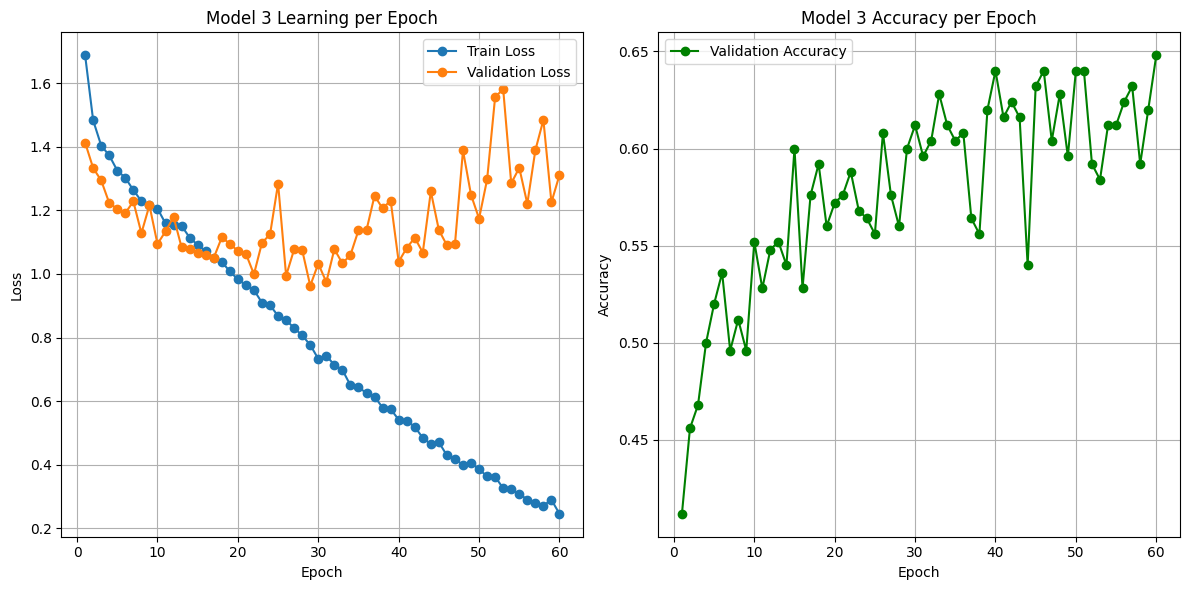

Model3 is saved to: CAS771/Task2_data/model3_all.pth


In [495]:
models, optimizers, criterions = get_models(gModel_names, gOptimizer_names, gCriterion_names)

for m in range(gnDataset):
    model = models[m]
    optimizer = optimizers[m]
    criterion = criterions[m]
    train_dataloader, test_dataloader = load_data(train_data_paths[m], test_data_paths[m], m)

        # 각 모델별로 학습 데이터에서 샘플 이미지 출력
    show_sample_images(train_dataloader, gModel_names[m], num_images=5)

    progress = CAS771Plot(model, criterion, device, train_dataloader, test_dataloader, m)
    es = CAS771EarlyStopping()

    for epoch in range(gnEpochs):
        model.train()
        progress.init_running_loss()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device) # move data to GPU/CPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            progress.add_loss(loss.item())
        
        val_loss, val_acc = progress.append(epoch)
        if es.isStop(val_loss, val_acc, m):
            break
    progress.plot()
    save_model(model, m, gSaveModelAll)

    del model
torch.cuda.empty_cache()

